# Integrator
## Verlet
- like Euler numerical procedure for solving ODEs but with lower false
- approximating the integral with the finite sum by the Taylor expansion
- the cubic and higher-order terms are ignored
Approximation

$$
x(t+\tau)\approx x(t)+\tau \,v(t)-\frac{\tau ^2}{2m}\nabla\phi(x(t))\\
v(t+\tau)\approx v(t)-\frac{\tau }{2m}\left(\nabla\phi(x(t))+\nabla\phi(x(t+\tau))\right)
$$

### Goals
- setup of the algorithm 
    - parameters  
    - inputs
- timing
- 1D, 2D and 3D distinction
- vectorization
- testing
    - ZeroDivisionError, NameError and TypeErrorn ValueError, Type,Error, RuntimeError, IOError
    - functionality
    - ??
- visualisation
    - timing
    - stability
    - ??
    
### Advantage:
- Reversible integrator 
- symplectic
- Simple integrator not converting 

=> more stable and energy-conserving integrator than Euler


In [1]:
%matplotlib notebook
import numpy as np
#import timeit
import matplotlib.pyplot as plt
#from matplotlib import animation, rc
#from IPython.display import HTML

In [2]:
# wehmeyer
def vvW(potential_gradient, size, x_init, v_init, mass=1.0, time_step=0.005):
    x, v = np.zeros(size), np.zeros(size)
    x[0], v[0] = x_init, v_init
    nabla_u1, nabla_u0 = potential_gradient(x[0]), None
    for i in range(1, size):
        x[i] = x[i - 1] + time_step * v[i - 1] - time_step**2 * nabla_u1 / 2 / mass
        nabla_u1, nabla_u0 = potential_gradient(x[i]), nabla_u1
        v[i] = v[i - 1] - time_step * (nabla_u1 + nabla_u0) / 2 / mass
    return x, v

#### VV-algorithm, open system

In [3]:
def potential_gradient(p,k=1):
    return k*p

In [4]:
def vvJ(potential_gradient, position_init, velocity_init, mass, T, time_step):
    size = int(T/time_step)        # number of time steps
    n = len(position_init)         # number of particles
    dim = position_init.shape[-1]  # number of dimension
    m = mass
    # creating positiion, velocity and acceleration container
    position_matrix, velocity_matrix, acceleration_matrix = np.zeros((size, n, dim)), np.zeros((size, n, dim)), np.zeros((size, n, dim))
    # initialization by adding the start configuration
    position_matrix[0], velocity_matrix[0], acceleration_matrix[0] = position_init, velocity_init, potential_gradient(position_init)
    # time iteration
    for t in range(1, size):
        # rename # kostet das rechenleistung ? bennenung lieber von anfang anders?
        p = position_matrix[t-1]
        v = velocity_matrix[t-1]
        a = acceleration_matrix[t]
        gp = potential_gradient(p)
        # vv approximation
        p_new = p + time_step*v - (time_step**2)/(2*m)*gp
        gp_new = potential_gradient(p_new) 
        v_new = v - time_step/(2*m) * (gp + gp_new)
        a = gp_new
        #v_new[:,1][p_new[:,1]<0]*=-1 ???
        # write in pos and vel container
        #position_matrix[t], velocity_matrix[t] = p_new, v_new
        position_matrix[t], velocity_matrix[t], acceleration_matrix[t] = p_new, v_new, a
    # returning position and velocety container
    return position_matrix, velocity_matrix, acceleration_matrix

<IPython.core.display.Javascript object>


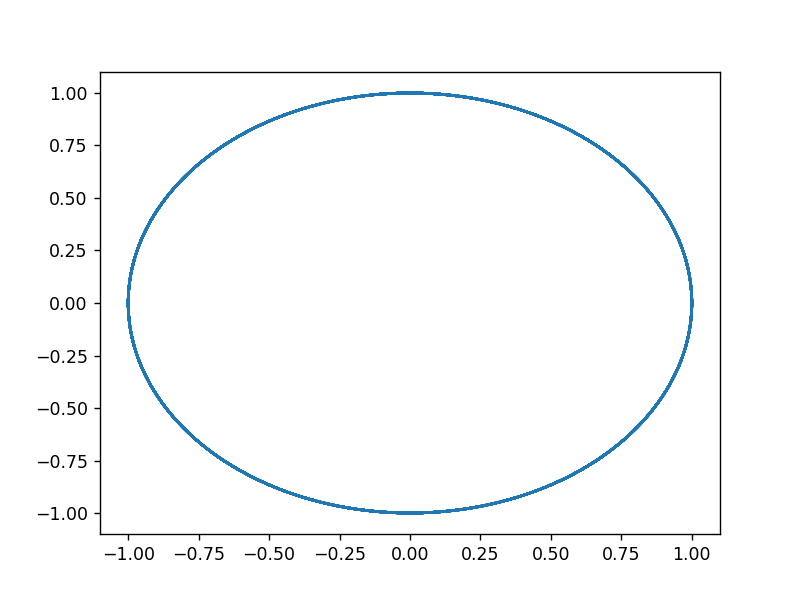

In [5]:
# testing 
#p_0 = np.array([[1., 0.]])
#v_0 = np.array([[20., 200.5]])
p_0 = np.array([[1., 0., 0.], [1., 0., 0.]])
v_0 = np.array([[0., 0., 0.], [0., 0., 0.]])
m = np.array([[1.], [1.]])

res = vvJ(potential_gradient, p_0, v_0, m, 100, 1/100)
res
#print(a[0][:,0,0])
plt.plot(res[0][:,0, 0], res[1][:,0,0])

### closed system , non pbc

In [6]:
def potential_gradient(p,k=10):
    return k*p

def boundary(p, p_max):
    p_r = p_max - p_max/4
    p_l = p_max/4
    V_end_r = 4 * np.abs(p-p_r)**2*np.heaviside(np.abs(p-p_r))
    V_end_l = 4 * np.abs(p-p_l)**2*np.heaviside(np.abs(p-p_l))
    return V_end_r + V_end_l

def potential():
    return potantial_gradient + boundary

In [7]:
def vvJ(potential_gradient, position_init, velocity_init, mass, T, time_step):
    size = int(T/time_step)        # number of time steps
    n = len(position_init)         # number of particles
    dim = position_init.shape[-1]  # number of dimension
    m = mass
    # creating positiion, velocity and acceleration container
    position_matrix, velocity_matrix, acceleration_matrix = np.zeros((size, n, dim)), np.zeros((size, n, dim)), np.zeros((size, n, dim))
    # initialization by adding the start configuration
    position_matrix[0], velocity_matrix[0], acceleration_matrix[0] = position_init, velocity_init, potential_gradient(position_init)
    # time iteration
    for t in range(1, size):
        # rename # kostet das rechenleistung ? bennenung lieber von anfang anders?
        p = position_matrix[t-1]
        v = velocity_matrix[t-1]
        a = acceleration_matrix[t]
        gp = potential_gradient(p)
        # vv approximation
        p_new = p + time_step*v - (time_step**2)/(2*m)*gp
        gp_new = potential_gradient(p_new) 
        v_new = v - time_step/(2*m) * (gp + gp_new)
        a = gp_new
        #v_new[:,1][p_new[:,1]<0]*=-1 ???
        # write in pos and vel container
        #position_matrix[t], velocity_matrix[t] = p_new, v_new
        position_matrix[t], velocity_matrix[t], acceleration_matrix[t] = p_new, v_new, a
    # returning position and velocety container
    return position_matrix, velocity_matrix, acceleration_matrix

In [8]:
p_max = np.array([[2., 3., 2.], [2., 3., 2.]])
p_0 = np.array([[1., 0., 0.], [1., 0., 0.]])
v_0 = np.array([[0., 0., 0.], [0., 0., 0.]])
m = np.array([[1., 1., 1.], [1., 1., 1.]])

res = vvJ(potential_gradient, p_0, v_0, m, 10, 1/100)
res

(array([[[1.        , 0.        , 0.        ],
         [1.        , 0.        , 0.        ]],
 
        [[0.9995    , 0.        , 0.        ],
         [0.9995    , 0.        , 0.        ]],
 
        [[0.9980005 , 0.        , 0.        ],
         [0.9980005 , 0.        , 0.        ]],
 
        ...,
 
        [[0.99358892, 0.        , 0.        ],
         [0.99358892, 0.        , 0.        ]],
 
        [[0.98951751, 0.        , 0.        ],
         [0.98951751, 0.        , 0.        ]],
 
        [[0.98445659, 0.        , 0.        ],
         [0.98445659, 0.        , 0.        ]]]),
 array([[[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[-0.099975  ,  0.        ,  0.        ],
         [-0.099975  ,  0.        ,  0.        ]],
 
        [[-0.19985003,  0.        ,  0.        ],
         [-0.19985003,  0.        ,  0.        ]],
 
        ...,
 
        [[-0.35746132,  0.        ,  0.        ],
         [-0.35746132,  0.   